#  Uncertainty-Aware Deep Classifiers using Generative Models

In this notebook, we demonstrate how the evidential deep learning can be extended using generative models and implicit density modelling using the MNIST dataset. *It is prepared for colab, so you may need to clean colab specific code before running it in your machine.*

The code presented here is an implementation of the approach proposed in the following paper:

Murat Sensoy, Lance Kaplan, Federico Cerutti, Maryam Saleki, “Uncertainty-Aware Deep Classifiers using Generative Models”,  The 34rd Conference on Artificial Intelligence (AAAI), 2020. 

The notebook can be accesed over https://muratsensoy.github.io/gen.ipynb


In [0]:
%tensorflow_version 1.x

#import necessary libraries
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import scipy.ndimage as nd

%matplotlib inline
import pylab as pl
from IPython import display

from tensorflow.examples.tutorials.mnist import input_data
from tensorflow_probability import distributions as tfd
from sklearn.metrics import roc_curve, precision_recall_curve, auc

In [0]:
#optional: define which GPU will be used
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
# change path to out-of-distribution samples (e.g., notMNIST)
#notmnist = np.load('data/notMNIST_real/notMNIST_small/'+'dataset.npy')

# use fashionmnist for convenience (keras)
from keras.datasets import fashion_mnist
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
OoD = testX/255


Using TensorFlow backend.


In [0]:
train_inds = range(1,OoD.shape[0],2)

In [5]:
# Download MNIST dataset
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

K= 10 # number of classes

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


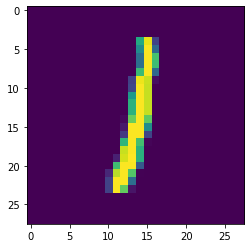

In [6]:
digit_one = mnist.train.images[4].copy()
plt.imshow(digit_one.reshape(28,28)) 
plt.show()

In [0]:
# define some utility functions
def var(name, shape, init=None):
    if init is None:
        init = tf.truncated_normal_initializer(stddev=(2/shape[0])**0.5)
    return tf.get_variable(name=name, shape=shape, dtype=tf.float32,
                          initializer=init)

def conv(Xin, f, strides=[1, 1, 1, 1], padding='SAME'):
    return tf.nn.conv2d(Xin, f, strides, padding)

def max_pool(Xin, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'):
    return tf.nn.max_pool(Xin, ksize, strides, padding)

def rotate_img(x, deg):
    import scipy.ndimage as nd
    return nd.rotate(x.reshape(28,28),deg,reshape=False).ravel()

In [0]:
# This method rotates an image counter-clockwise and classify it for different degress of rotation. 
# It plots the highest classification probability along with the class label for each rotation degree.
def rotating_image_classification(img, sess, prob, X, keep_prob, uncertainty=None, prob_threshold=0.5):
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,K))
    rimgs = np.zeros((28,28*Ndeg))
    for i,deg in enumerate(np.linspace(0,Mdeg, Ndeg)):
        nimg = rotate_img(img,deg).reshape(28,28)
        nimg = np.clip(a=nimg,a_min=0,a_max=1)
        rimgs[:,i*28:(i+1)*28] = nimg
        if keep_prob is not None:
            feed_dict={X:nimg.reshape(1,-1), keep_prob:1.0}
        else:
            feed_dict={X:nimg.reshape(1,-1)}
        if uncertainty is None:
            p_pred_t = sess.run(prob, feed_dict=feed_dict)
        else:
            p_pred_t,u = sess.run([prob,uncertainty], feed_dict=feed_dict)
            lu.append(u.mean())
        scores += p_pred_t >= prob_threshold
        ldeg.append(deg) 
        lp.append(p_pred_t[0])
    
    labels = np.arange(10)[scores[0].astype(bool)]
    lp = np.array(lp)[:,labels]
    c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*2
    labels = labels.tolist()
    for i in range(len(labels)):
        plt.plot(ldeg,lp[:,i],marker=marker[i],c=c[i])
    
    if uncertainty is not None:
        labels += ['uncertainty']
        plt.plot(ldeg,lu,marker='<',c='red')
        
    plt.legend(labels)
 
    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Classification Probability')
    plt.show()

    plt.figure(figsize=[6.2,100])
    plt.imshow(1-rimgs,cmap='gray')
    plt.axis('off')
    plt.show()

In [0]:
def exp_evidence(logits): 
    return tf.exp(logits)

def KL(alpha):
    K=alpha.get_shape()[-1].value
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keep_dims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keep_dims=True)
    lnB = tf.lgamma(S_alpha) - tf.reduce_sum(tf.lgamma(alpha),axis=1,keep_dims=True)
    lnB_uni = tf.reduce_sum(tf.lgamma(beta),axis=1,keep_dims=True) - tf.lgamma(S_beta)
    
    dg0 = tf.digamma(S_alpha)
    dg1 = tf.digamma(alpha)
    
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keep_dims=True) + lnB + lnB_uni
    return kl

In [0]:
def calc_entropy(p):
    return (-p*np.log(p+1e-8)).sum(1)

# Define the generative models

In [0]:
def disc(x, name='disc',K=10):
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        x_inp = tf.reshape(x, [-1, 28, 28, 1])
        
        regularizer = tf.contrib.layers.l2_regularizer(scale=0.001)


        x = tf.layers.conv2d(inputs=x_inp, kernel_size=5, filters=20,
                         activation=tf.nn.relu, padding='VALID',
                         kernel_regularizer=regularizer,
                         kernel_initializer=tf.variance_scaling_initializer())
        x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                       padding='SAME')

        x = tf.layers.conv2d(inputs=x, kernel_size=5, filters=50,
                         activation=tf.nn.relu, padding='VALID',
                         kernel_regularizer=regularizer,
                         kernel_initializer=tf.variance_scaling_initializer())
        x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                       padding='SAME')

        x = tf.layers.flatten(x)

        x = tf.layers.dense(inputs=x, units=500, activation=tf.nn.relu,
                        kernel_regularizer=regularizer,
                        kernel_initializer=tf.variance_scaling_initializer())

        x = tf.layers.dense(inputs=x, units=K,
                        kernel_regularizer=regularizer,
                        kernel_initializer=tf.variance_scaling_initializer())

        return x

In [0]:
layers_g = [{'filters': 256, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'valid'},
            {'filters': 128, 'kernel_size': [5, 5], 'strides': [2, 2], 'padding': 'same'},
            {'filters': 1, 'kernel_size': [5, 5], 'strides': [2, 2], 'padding': 'same'}]
    
def imgen(x):
    if len(x.get_shape()) == 2:
        m = x.get_shape()[1]
        layer = tf.reshape(x, [-1, 1, 1, m])
    else:
        layer = x

    depth = len(layers_g)
    for i in range(depth):
        layer_config = layers_g[i]
        is_output = ((i + 1) == depth)

        conv2d = tf.layers.conv2d_transpose(
                    layer, 
                    filters = layer_config['filters'], 
                    kernel_size = layer_config['kernel_size'], 
                    strides = layer_config['strides'], 
                    padding = layer_config['padding'],
                    activation = tf.nn.tanh if is_output else None,
                    kernel_initializer = tf.truncated_normal_initializer(stddev=0.02), 
                    name = 'layer_' + str(i))

        if is_output:
            layer = conv2d
        else:
            norm = tf.layers.batch_normalization(conv2d, training=True)
            lrelu = tf.nn.leaky_relu(norm)
            layer = lrelu
                
    # [M, img_size, img_size, img_channels]
    output = tf.identity(layer, name='generated_images')
    return output 

def encoder(x, n=100):
    with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE):
        x = tf.reshape(x, [-1, 28, 28, 1])
        x = tf.layers.conv2d(x, 20, 5, activation=tf.nn.relu)
        x = tf.layers.max_pooling2d(x, 2, 2)

        x = tf.layers.conv2d(x, 50, 5, activation=tf.nn.relu)
        x = tf.layers.max_pooling2d(x, 2, 2)

        x = tf.layers.flatten(x)

        loc = tf.layers.dense(x, n)
        scale = tf.layers.dense(x, n, tf.nn.softplus)
        code = tfd.MultivariateNormalDiag(loc, scale).sample()
    return code

def make_prior(code_size):
    loc = tf.zeros(code_size)
    scale = tf.ones(code_size)
    return tfd.MultivariateNormalDiag(loc, scale)



def decoder(code):
    with tf.variable_scope('decoder', reuse=tf.AUTO_REUSE):
        recon = imgen(code)
    return recon

def gen(code):
    with tf.variable_scope('gen', reuse=tf.AUTO_REUSE):
        n = tf.shape(code)[0]
        m = code.get_shape()[1]
        x = tf.concat((tf.random_normal(shape=(n, 2)), code), 1)
        x = tf.layers.dense(x, 32, tf.nn.leaky_relu)
        x = tf.layers.dense(x, 32, tf.nn.leaky_relu)
        x = tf.layers.dense(x, 32, tf.nn.leaky_relu)
        std = tf.layers.dense(x, m, tf.nn.softplus) 
    return std

def diz(x): # the discriminator in latent space
    with tf.variable_scope('diz', reuse=tf.AUTO_REUSE):
        regularizer = tf.contrib.layers.l2_regularizer(scale=0.001)
        x = tf.layers.dense(x, 32, tf.nn.leaky_relu, kernel_regularizer=regularizer, bias_regularizer=regularizer)
        x = tf.layers.dense(x, 32, tf.nn.leaky_relu, kernel_regularizer=regularizer, bias_regularizer=regularizer)
        x = tf.layers.dense(x, 32, tf.nn.leaky_relu, kernel_regularizer=regularizer, bias_regularizer=regularizer)
        x = tf.layers.dense(x, 1, kernel_regularizer=regularizer, bias_regularizer=regularizer)
    return x

def wloss(logits, maximize=True ):
    labels = tf.ones_like(logits) if maximize else tf.zeros_like(logits)
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))

def autoencoder(X=None, n=100):
    if X is None:
        X = tf.placeholder(shape=[None,28*28], dtype=tf.float32)
    code = encoder(X,n) 
          
    std = gen(code)
    pdf = tfd.MultivariateNormalDiag(loc=code, scale_diag=(std+1e-3))
    fake = pdf.sample()
    
    rlogits = diz(code)
    r_p = tf.nn.sigmoid(rlogits)
    
    flogits = diz(fake)
    f_p = tf.nn.sigmoid(flogits)
    
    recon = decoder(code) 
    Xfake = decoder(fake)   
    
    real_logits = disc(X,'disc0')
    real_p = tf.nn.sigmoid(real_logits)
    
    fake_logits = disc(Xfake,'disc0')
    fake_p = tf.nn.sigmoid(fake_logits)
        
    prior = make_prior(code_size=n)
        
    kl = -tf.reduce_mean(prior.log_prob(code))
    kl_fake = -tf.reduce_mean(prior.log_prob(fake))
    
        
    ae_vars = [v for v in tf.trainable_variables() if 'encoder/' in v.name or 'decoder/' in v.name]
    gen_vars = [v for v in tf.trainable_variables() if 'gen/' in v.name]
    disc_vars = [v for v in tf.trainable_variables() if 'disc0/' in v.name]
    diz_vars = [v for v in tf.trainable_variables() if 'diz/' in v.name]
    
    
    loss_diz = tf.reduce_mean(-tf.log(r_p+1e-8)) + tf.reduce_mean(-tf.log(1-f_p+1e-8)) 
    
    loss_disc = tf.reduce_mean(-tf.log(real_p+1e-8)) + tf.reduce_mean(-tf.log(1-fake_p+1e-8))  
    
    loss_gen = tf.reduce_mean(-tf.log(1-fake_p+1e-8))  + tf.reduce_mean(-tf.log(f_p+1e-8))
    
    recon = tf.layers.flatten(recon)
    rec_loss = tf.reduce_mean( tf.reduce_sum(tf.square(recon-X),1) + 1e-4) + 0.1*kl
    rec_loss += wloss(flogits, False)
    rec_step = tf.train.AdamOptimizer().minimize(rec_loss, var_list=ae_vars)
        
    diz_step = tf.train.RMSPropOptimizer(1e-4).minimize(loss_diz, var_list=diz_vars)
    disc_step = tf.train.RMSPropOptimizer(1e-4).minimize(loss_disc, var_list=disc_vars)
    gen_step = tf.train.RMSPropOptimizer(1e-4).minimize(loss_gen, var_list=gen_vars)
    
    rec_step = tf.group([rec_step for _ in range(10)])
    
    step = tf.group([rec_step, diz_step, disc_step, gen_step])
    return X, Xfake, code, recon, rec_loss, step

In [0]:
def misleading_alpha(alpha, y):
    K = y.get_shape()[-1].value
    indices = tf.where(tf.equal(y, tf.constant(0, dtype=tf.float32)))
    alp = tf.gather_nd(alpha, indices)
    alp = tf.reshape(alp, [-1, K - 1])
    return alp

def loss_fn(Y, evidence, real_p, fake_p):
    disc_loss = tf.reduce_mean(tf.reduce_sum(-Y * tf.log(real_p + 1e-5), axis=1) +
                               tf.reduce_sum(-Y * tf.log((1.0 - fake_p) + 1e-5), axis=1))
    alp = misleading_alpha(evidence+1, Y)
    disc_loss += tf.reduce_mean(KL(alp))
    return disc_loss

In [0]:
# train LeNet network
def LeNet(logits2evidence=exp_evidence, lmb=0.005,K=10):
    g = tf.Graph()
    with g.as_default():
        X = tf.placeholder(shape=[None,28*28], dtype=tf.float32)
        Y = tf.placeholder(shape=[None,K], dtype=tf.float32) 
        adv_eps = tf.placeholder(dtype=tf.float32)   
    
        recon=None
        _, X_fake, code, recon, rec_loss, step_gen = autoencoder(X)
        
        real_logits = disc(X,K=K)
        real_p = tf.nn.sigmoid(real_logits)
        
        fake_logits = disc(X_fake,K=K)
        fake_p = tf.nn.sigmoid(fake_logits)
        
        evidence = logits2evidence(real_logits)
        alpha = evidence + 1
        
        u = K / tf.reduce_sum(alpha, axis=1, keep_dims=True) #uncertainty
        
        prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
        
        
        var_disc = [v for v in tf.trainable_variables() if 'disc/' in v.name]
        
        l2_loss = tf.losses.get_regularization_loss()
        
        disc_loss = tf.reduce_mean(tf.reduce_sum(-Y*tf.log(real_p + 1e-8), axis=1) + 
                            tf.reduce_sum(-(1-Y)*tf.log(1.0-real_p + 1e-8), axis=1) +
                            tf.reduce_sum(-tf.log((1.0-fake_p) + 1e-8), axis=1))
        
        disc_loss = loss_fn(Y, evidence, real_p, fake_p)
        
        
        step_disc = tf.train.AdamOptimizer().minimize(disc_loss + l2_loss, var_list = var_disc)
        
        
        loss_grads = tf.gradients(disc_loss, X)[0]
        adv_x = X + adv_eps * tf.sign(loss_grads) 
        
        step = tf.group([step_disc, step_gen])
        
        # Calculate accuracy
        pred = tf.argmax(real_logits, 1)
        truth = tf.argmax(Y, 1)
        match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
        acc = tf.reduce_mean(match)
        
        total_evidence = tf.reduce_sum(evidence,1, keepdims=True) 
        mean_ev = tf.reduce_mean(total_evidence)
        mean_ev_succ = tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*match) / tf.reduce_sum(match+1e-20)
        mean_ev_fail = tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*(1-match)) / (tf.reduce_sum(tf.abs(1-match))+1e-20) 
        
        return g, step, X, Y, adv_eps, adv_x, recon, prob, acc, disc_loss, u, evidence, mean_ev, mean_ev_succ, mean_ev_fail, real_logits, X_fake

In [15]:
g, step, X, Y, adv_eps, adv_x, recon, prob, acc, loss, u, evidence, mean_ev, mean_ev_succ, mean_ev_fail, logits, X_fake = LeNet(exp_evidence)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions fo

In [0]:
sess = tf.Session(graph=g)
with g.as_default():
    sess.run(tf.global_variables_initializer())

In [0]:
def get_dataset(dataset,labels, digits):
    digits=np.array([digits])
    y = labels.argmax(1)[:,None] ==digits
    indx = (y.sum(1) > 0)
    return dataset[indx],y[indx].astype(float)

def next_batch(data,labels, i, bsz):
    i = i % (data.shape[0]//bsz)
    return data[i*bsz:(i+1)*bsz], labels[i*bsz:(i+1)*bsz], np.arange(data.shape[0])[i*bsz:(i+1)*bsz]

In [0]:
in_labels = [1,8]
out_labels = list(set(range(10))-set(in_labels))
x_train, y_train = get_dataset(mnist.train.images,mnist.train.labels,in_labels)
x_test,y_test = get_dataset(mnist.test.images,mnist.test.labels,in_labels)
x_out, y_out = get_dataset(mnist.test.images,mnist.test.labels,out_labels)

In [0]:
x_train, y_train =  mnist.train.images,mnist.train.labels
x_test,y_test =  mnist.test.images,mnist.test.labels

In [0]:
bsize = 1000 #batch size
n_batches = mnist.train.num_examples // bsize
L_train_acc1=[]
L_train_ev_s=[]
L_train_ev_f=[]
L_test_acc1=[]
L_test_ev_s=[]
L_test_ev_f=[]
for epoch in range(0,50):   
    for i in range(n_batches):
        
        #data, label = mnist.train.next_batch(bsize)
        data,label,_ = next_batch(x_train,y_train, i,bsize)
        
        feed_dict={X:data, Y:label}
        sess.run(step,feed_dict)
        print('epoch %d - %d%%) '% (epoch+1, (100*(i+1))//n_batches), end='\r' if i<n_batches-1 else '')
        
    train_acc, train_succ, train_fail = sess.run([acc,mean_ev_succ,mean_ev_fail], 
                                                  feed_dict={X:x_train,Y:y_train})
    test_acc, test_succ, test_fail = sess.run([acc,mean_ev_succ,mean_ev_fail], 
                                               feed_dict={X:x_test,Y:y_test})
    
    L_train_acc1.append(train_acc)
    L_train_ev_s.append(train_succ)
    L_train_ev_f.append(train_fail)
    
    L_test_acc1.append(test_acc)
    L_test_ev_s.append(test_succ)
    L_test_ev_f.append(test_fail)
    
    print('training: %2.4f (%2.4f - %2.4f) \t testing: %2.4f (%2.4f - %2.4f)' % 
          (train_acc, train_succ, train_fail, test_acc, test_succ, test_fail))

# Some generated fake images

In [0]:
def get_image(data):
    n = int(data.shape[0]**0.5)
    m = int(np.ceil(data.shape[0]/n))
    I = np.zeros((n*28,m*28))
    for i in range(n):
        for j in range(m):
            I[i*28:(i+1)*28,j*28:(j+1)*28] = data[i*m+j].reshape(28,28)
    return I

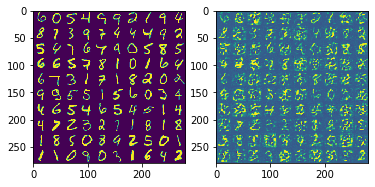

In [22]:
org = get_image(x_test[100:200])
fake = get_image(sess.run(X_fake, {X:x_test[100:200]})[:,:,:,0])
plt.subplot(1,2,1)
plt.imshow(org)
plt.subplot(1,2,2)
plt.imshow(fake)

# Image Rotation Test

In [0]:
def roc_test(x_test=x_test, x_out=x_out):
    normal = x_test
    anormal = x_out[:normal.shape[0]]
    truth = np.ones((normal.shape[0]+anormal.shape[0],))
    truth[normal.shape[0]:]=0
    imgs = np.concatenate((normal,anormal),0)
    ev = sess.run(evidence, feed_dict={X:imgs}).sum(1)

    fpr, tpr, roc_thresholds = roc_curve(truth, ev)
    roc_auc = auc(fpr, tpr)

    print('roc:',roc_auc)

In [24]:
roc_test()

roc: 0.5263634710429603


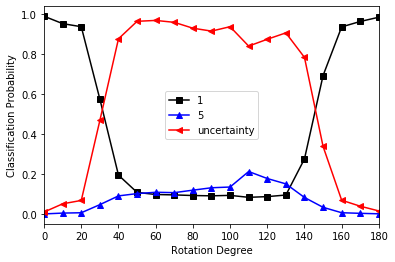

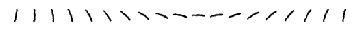

In [25]:
rotating_image_classification(digit_one, sess, prob, X, None, u, prob_threshold=0.2)

# Entropy as Predictive Uncertainy (correct vs wrong predictions)

In [0]:
test_acc, ev = sess.run([acc,evidence], feed_dict={X:mnist.test.images,Y:mnist.test.labels})

In [0]:
match = (ev.argmax(1)==mnist.test.labels.argmax(1))
succ_ev = ev[match]
fail_ev = ev[(1-match).astype(bool)]

u_succ = 10/(10+succ_ev.sum(1))
u_fail = 10/(10+fail_ev.sum(1))

p_succ = (succ_ev+1)/(10+succ_ev.sum(1,keepdims=True))
p_fail = (fail_ev+1)/(10+fail_ev.sum(1,keepdims=True))

(array([ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  6., 11., 87.]),
 array([0.5332799 , 0.7102089 , 0.88713795, 1.064067  , 1.240996  ,
        1.417925  , 1.594854  , 1.771783  , 1.9487121 , 2.125641  ,
        2.30257   ], dtype=float32),
 <a list of 10 Patch objects>)

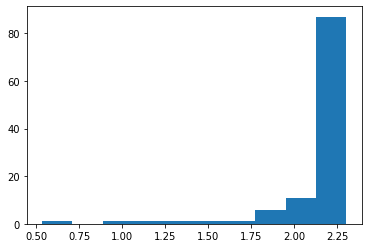

In [28]:
plt.hist(calc_entropy(p_fail))

(array([3767., 1654., 1005.,  653.,  508.,  487.,  394.,  336.,  375.,
         711.]),
 array([0.00519714, 0.2349359 , 0.46467465, 0.69441336, 0.92415214,
        1.1538908 , 1.3836297 , 1.6133684 , 1.8431071 , 2.072846  ,
        2.3025846 ], dtype=float32),
 <a list of 10 Patch objects>)

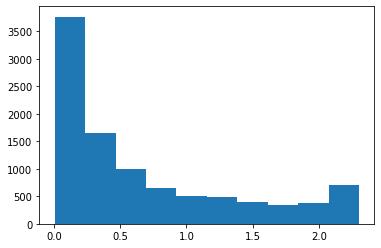

In [29]:
plt.hist(calc_entropy(p_succ))

# Subjective Logic's Uncertainty (K/S)

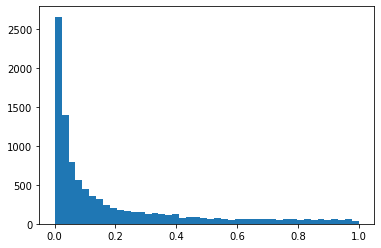

In [30]:
a_=plt.hist(u_succ, bins='auto')

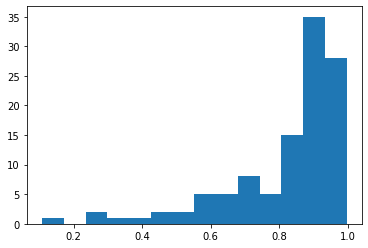

In [31]:
a_=plt.hist(u_fail, bins='auto')

# Emprical PDF for Entropy for Out-of-Distribution (OoD) Samples

In [0]:
p_OoD=sess.run(prob, feed_dict={X:OoD.reshape(-1,28*28)})

In [0]:
def entropy(p):
    return (-p*np.log(p+1e-8)).sum(1)

In [0]:
def empCDF(entropy,n=10): 
    x = np.linspace(0,np.log(n), 1000)
    y = np.zeros_like(x)
    for i, val in enumerate(x):
        y[i] = np.mean(entropy<=val)
    return entropy, x,y

In [0]:
_,x,y=empCDF(entropy(p_OoD))

In [0]:
np.save('entropy_mnist_edl_gan_outlier',entropy)

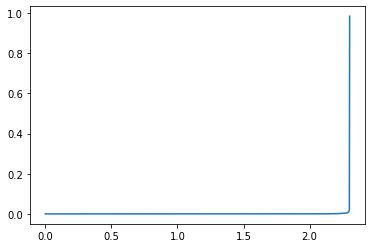

In [37]:
plt.plot(x,y)

# Emprical PDF for Entropy for correct and wrong predictions

In [0]:
_,x1,y1=empCDF(entropy(p_succ))

(0, 1)

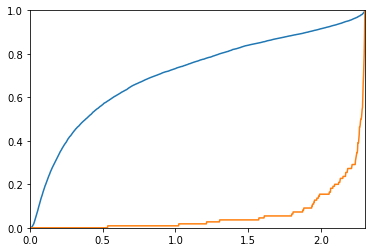

In [39]:
_,x2,y2=empCDF(entropy(p_fail))
plt.plot(x1,y1)
plt.plot(x2,y2)
plt.xlim([0,np.log(10)])
plt.ylim([0,1])

# OoD Detection using Entropy of Predictions

In [0]:
normal = mnist.test.images
anormal = OoD.reshape(-1,28*28)

truth = np.ones((normal.shape[0]+anormal.shape[0],))
truth[normal.shape[0]:]=0
imgs = np.concatenate((normal,anormal),0)

In [0]:
ev = sess.run(evidence, feed_dict={X:imgs})

In [0]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

fpr, tpr, roc_thresholds = roc_curve(truth, ev.sum(1))
roc_auc = auc(fpr, tpr)

In [43]:
roc_auc

0.9993710499999999

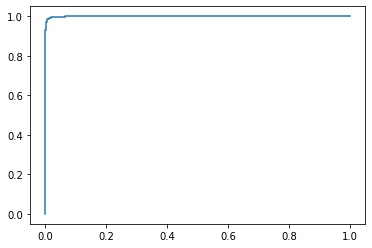

In [44]:
plt.plot(fpr,tpr)